<a href="https://colab.research.google.com/github/Wonhochoi123/Skin_Cancer_Detection_-Final_Project-/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#Let's start with importing most of the modules to use to begin with
from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, img_to_array
import keras.utils # convert to one-hot-encoding

import tensorflow as tf
from sklearn.utils import class_weight

import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt 

In [18]:
#setting the base model
resent_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=[150,150,3])

In [19]:
for layer in resent_model.layers:
    layer.trainable = False

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

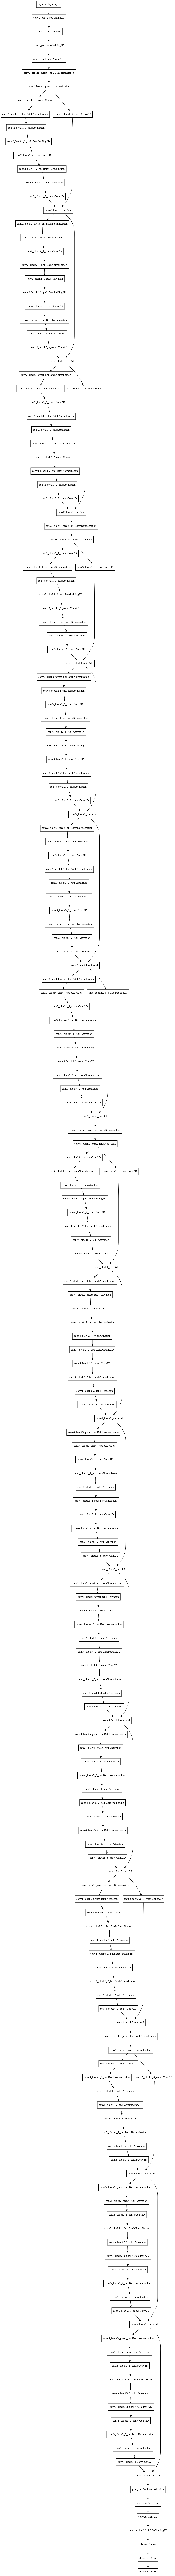

In [20]:
# A little bit of customization
x = Conv2D(128, (3, 3), activation='relu')(resent_model.output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = Dense(8,activation='softmax')(x)

model = Model(inputs=resent_model.input, outputs=x)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
print(model.summary())
keras.utils.plot_model(model)

In [21]:
#let's set up how we would train the model
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    horizontal_flip = True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Final_Project/dataset2/classes_train',
                                                 target_size = (150,150),
                                                 batch_size = 256,
                                                 class_mode = 'categorical')


testing_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Final_Project/dataset2/classes_test',
                                               target_size = (150,150),
                                               batch_size = 256,
                                               class_mode = 'categorical')


Found 20262 images belonging to 8 classes.
Found 5069 images belonging to 8 classes.


In [22]:

#This is how the classes coded
training_set.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

In [23]:
# In order to make class_weight dictionary, I'm making a dict of class:count
import glob
labels_dict={}
for i in training_set.class_indices:

  labels_dict[training_set.class_indices[str(i)]]=len(glob.glob("/content/drive/MyDrive/Final_Project/dataset2/classes_train/"+i+"/*.jpg"))


In [24]:
# It's a very imbalanced data! We better weigh differenty by class
labels_dict

{0: 693, 1: 2658, 2: 2099, 3: 191, 4: 3617, 5: 10300, 6: 502, 7: 202}

In [25]:
import numpy as np
import math
# formula for class_weight

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    
    for key in keys:
        score = (mu*total/(2*float(labels_dict[key])))
        class_weight[key] = score 
    
    return class_weight

In [26]:
class_weight=create_class_weight(labels_dict)

In [27]:
class_weight

{0: 2.1928571428571426,
 1: 0.571726862302483,
 2: 0.7239876131491185,
 3: 7.956282722513088,
 4: 0.42014100082941663,
 5: 0.1475388349514563,
 6: 3.0271912350597607,
 7: 7.5230198019801975}

In [28]:
training_set.classes

array([0, 0, 0, ..., 7, 7, 7], dtype=int32)

In [30]:
#And now we are fitting the model.
hist = model.fit(training_set,
                validation_data = testing_set,
                epochs = 40,
                steps_per_epoch=len(training_set),
                validation_steps=len(testing_set))

Epoch 1/40
 1/80 [..............................] - ETA: 3:28:54 - loss: 2.6421 - accuracy: 0.3164

KeyboardInterrupt: ignored

In [ ]:
result

In [ ]:
model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
result

In [ ]:
y_true = testing_set.classes
y_pred = model.predict(testing_set)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))

In [ ]:
clr = classification_report(y_true, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.04      0.05      0.04       174
           1       0.13      0.14      0.14       665
           2       0.08      0.05      0.06       525
           3       0.00      0.00      0.00        48
           4       0.17      0.12      0.14       905
           5       0.51      0.60      0.55      2575
           6       0.00      0.00      0.00       126
           7       0.00      0.00      0.00        51

    accuracy                           0.35      5069
   macro avg       0.12      0.12      0.12      5069
weighted avg       0.31      0.35      0.33      5069



5069

In [ ]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]

print("Test Accuracy: {:.3f}%".format(model_acc * 100))

ValueError: ignored

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')

plt.xticks(np.arange(7) + 0.5, label_mapping.values())
plt.xlabel("Predicted")

plt.yticks(np.arange(7) + 0.5, label_mapping.values())
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

NameError: ignored

<Figure size 720x720 with 0 Axes>

In [ ]:
print(clr)


NameError: ignored

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_6932.h5')